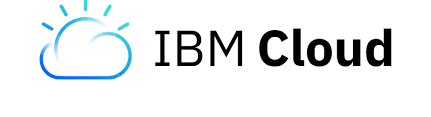

# Case Study - Data ingestion

The goal of this case study is to put into practice the important concepts from module 1.  We will go through the basic process that begins with refining the business opportunity and ensuring that it is articulated using a scientific thought process.

The business opportunity and case study was first mentioned in Unit 2 of module 1 and like the AAVIAL company itself these data were created for learning purposes.  We will be using the AAVAIL example as a basis for this case study. You will be gathering data from several provided sources, staging it for quality assurance and saving it in a target destination that is most appropriate.


## Case study overall objectives

1. Gather all relevant data from the sources of provided data
2. Implement several checks for quality assurance 
3. Take the initial steps towards automation of the ingestion pipeline

## Getting started

Download this notebook and open it locally using a Jupyter server. Alternatively you may use Watson Studio.  To make using Watson Studio easier we have provided a zip archive file containing the files needed to complete this case study in Watson Studio. See the [Getting started with Watson Studio](m1-u5-5-watson-studio.rst) page.

**You will need the following files to complete this case study**

* [m1-u6-case-study.ipynb](m1-u6-case-study.ipynb)
* [aavail-customers.db](./data/aavail-customers.db)
* [aavail-steams.csv](./data/aavail-streams.csv)

1. Fill in all of the places in this notebook marked with ***YOUR CODE HERE*** or ***YOUR ANSWER HERE***
2. When you have finished the case study there will be a short quiz

You may review the rest of this content as part of the notebook, but once you are ready to get started be ensure that you are working with a *live* version either as part of Watson Studio or locally.

## Data Sources

The data you will be sourcing from is contained in two sources.

1. A database ([SQLite](https://www.sqlite.org/index.html)) of `customer` data
2. A [CSV file](https://en.wikipedia.org/wiki/Comma-separated_values) of `stream` level data

   >You will create a simple data pipeline that
   (1) simplifies the data for future analysis
   (2) performs quality assurance checks.

The process of building *the data ingestion pipeline* entails extracting data, transforming it, and loading it into an appropriate data storage technology.  When constructing a pipeline it is important to keep in mind that they generally process data in batches.  For example, data may be compiled during the day and the batch could be processed during the night.  The data pipeline may also be optimized to execute as a streaming computation (i.e., every event is handled as it occurs).

## PART 1: Gathering the data

The following is an [Entity Relationship Diagram (ERD)](https://en.wikipedia.org/wiki/Entity%E2%80%93relationship_model) that details the tables and contents of the database.

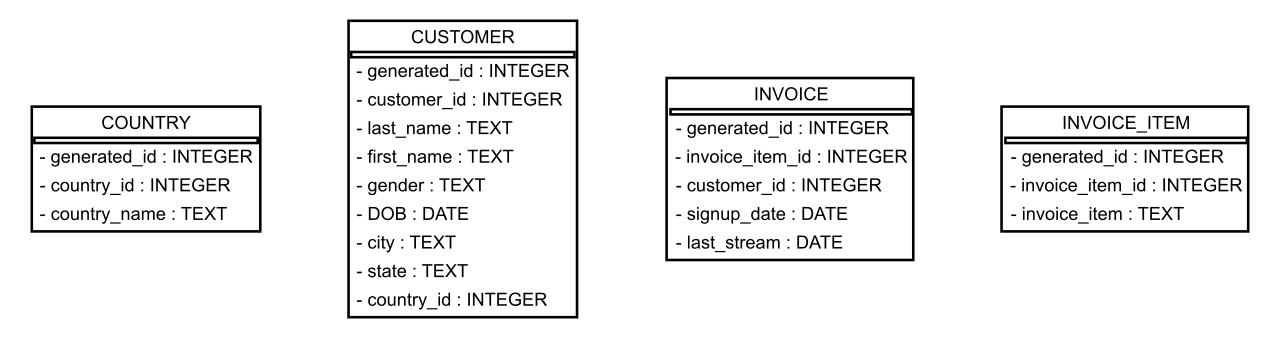

In [1]:
## all the imports you will need for this case study
import os
import pandas as pd
import numpy as np
import sqlite3

## specify the directory you saved the data in
data_dir = os.path.join(".","data")

Much of the data exist in a database.  You can connect to it using the `sqlite3` Python package with the function shown below.  Note that is is good practice to wrap your connect functions in a [try-except statement](https://docs.python.org/3/tutorial/errors.html) to cleanly handle exceptions.

In [2]:
def connect_db(file_path):
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db\n")
    except Error as e:
        print("...unsuccessful connection\n",e)
    
    return(conn)

In [3]:
## make the connection to the database
conn = connect_db(os.path.join(data_dir,"aavail-customers.db"))

## print the table names
tables = [t[0] for t in conn.execute("SELECT name FROM sqlite_master WHERE type='table';")]
print(tables)

...successfully connected to db

['CUSTOMER', 'INVOICE', 'INVOICE_ITEM', 'COUNTRY']


### QUESTION 1:

**extract the relevant data from the DB**

Query the database and extract the following data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).
 
* Customer ID (integer)
* Last name
* First name
* DOB (Date Of Birth)
* City
* State
* Country (the name NOT the country_id)
* Gender

Remember that that SQL is case-insensitive, but it is traditional to use ALL CAPS for SQL keywords. It is also a convention to end SQL statements with a semi-colon.  

#### Resources

* [W3 schools SQL tutorial](https://www.w3schools.com/sql)
* [W3 schools SQL joins](https://www.w3schools.com/sql/sql_join.asp)

In [4]:
## YOUR CODE HERE
query = """
SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
       cu.city, cu.state, co.country_name, cu.gender
FROM CUSTOMER cu
INNER JOIN COUNTRY co
ON cu.country_id = co.country_id;
"""

df_db = pd.read_sql_query(query, conn)
df_db.head()

,customer_id,last_name,first_name,DOB,city,state,country_name,gender
0,1,Todd,Kasen,07/30/98,Rock Hill,South Carolina,united_states,m
1,2,Garza,Ensley,04/12/89,singapore,None,singapore,f
2,3,Carey,Lillian,09/12/97,Auburn,Alabama,united_states,f
3,4,Christensen,Beau,01/28/99,Hempstead,New York,united_states,m
4,5,Gibson,Ernesto,03/23/98,singapore,None,singapore,m


### QUESTION 2:

**Extract the relevant data from the CSV file**

For each ```customer_id``` determine if a customer has stopped their subscription or not and save it in a dictionary or another data container.

In [5]:
df_streams = pd.read_csv(os.path.join(data_dir, r"aavail-streams.csv"))
df_streams.head()

,customer_id,stream_id,date,invoice_item_id,subscription_stopped
0,1,1420.0,2018-10-21,2.0,0
1,1,1343.0,2018-10-23,2.0,0
2,1,1756.0,2018-11-05,2.0,0
3,1,1250.0,2018-11-06,2.0,0
4,1,1324.0,2018-11-12,2.0,0


In [6]:
## YOUR CODE HERE

has_stopped = df_streams.groupby("customer_id").apply(lambda x : True if x['subscription_stopped'].max() > 0 else False)

## PART 2: Checks for quality assurance

Sometimes it is known in advance which types of data integrity issues to expect, but other times it is during the Exploratory Data Analysis (EDA) process that these issues are identified.  After extracting data it is important to include checks for quality assurance even on the first pass through the AI workflow.  Here you will combine the data into a single structure and provide a couple checks for quality assurance.

### QUESTION 3: 

**Implement checks for quality assurance**

1. In the customer dataframe loaded question 1, remove any repeat customers based on ```customer_id```
2. In the streams dataset, remove stream data that do not have an associated ```stream_id```
3. Check for missing values in both datasets.

In [7]:
## YOUR CODE HERE
print("\nCleaning Summary\n{}".format("-"*35))
size_before = len(df_db)
df_db.drop_duplicates(subset='customer_id', keep="first", inplace=True )
size_after = len(df_db)
print("... removed {} duplicate rows in db data".format(size_before-size_after))

size_before = len(df_streams)
df_streams = df_streams[~df_streams['stream_id'].isna()]
size_after = len(df_streams)
print("... removed {} missing stream ids".format(size_before-size_after))

print("\nMissing Value Summary\n{}".format("-"*35))
print("\ndf_db\n{}".format("-"*15))
print(df_db.isnull().sum(axis = 0))
print("\ndf_streams\n{}".format("-"*15))
print(df_streams.isnull().sum(axis = 0))


Cleaning Summary
-----------------------------------
... removed 7 duplicate rows in db data
... removed 1164 missing stream ids

Missing Value Summary
-----------------------------------

df_db
---------------
customer_id       0
last_name         0
first_name        0
DOB               0
city              0
state           300
country_name      0
gender            0
dtype: int64

df_streams
---------------
customer_id             0
stream_id               0
date                    0
invoice_item_id         0
subscription_stopped    0
dtype: int64


### QUESTION 4: 

**combine the data into a single data structure**

For this example, the two most convenient structures for this task are Pandas dataframes and NumPy arrays.  At a minimum ensure that your structure accommodates the following.

1. A column for `customer_id`
2. A column for `country`
3. A column for ```age``` that is created from ```DOB```
4. A column ```customer_name``` that is created from ```first_name``` and ```last_name```
5. A column to indicate churn called ```is_subscriber```
7. A column that indicates ```subscriber_type``` that comes from ```invoice_item``` 
6. A column to indicate the total ```num_streams```

> HINT: For the subscriber type use the most frequent invoice_item_id and link it to the relevant invoice_item thanks to the INVOICE table in the database

#### Resources

* [Python's datetime library](https://docs.python.org/3/library/datetime.html)
* [NumPy's datetime data type](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html)


In [8]:
## YOUR CODE HERE

# We create a copy of the customer data restricted to the customer_ids found in the stream data
df_clean = df_db[df_db['customer_id'].isin(df_streams['customer_id'].unique())].copy()

# Create customer_name column
df_clean['customer_name'] = df_clean['first_name'] +' '+ df_clean['last_name']

# Create age column from DOB
DT = pd.Timestamp('now')
df_clean['DOB'] = pd.to_datetime(df_clean['DOB'], format='%m/%d/%y') 
df_clean['DOB'] = df_clean['DOB'].where(df_clean['DOB'] < DT, df_clean['DOB'] -  np.timedelta64(100, 'Y'))
df_clean['age'] = (DT - df_clean['DOB']).astype('<m8[Y]')

# Create is_subscriber column 
df_clean['is_subscriber'] = df_clean.apply(lambda x : ~has_stopped[x['customer_id']], axis=1)

# Create num_streams column
df_num_streams_tmp = df_streams.groupby('customer_id')\
                                .size()\
                                .reset_index()
df_num_streams_tmp.columns = ['customer_id', 'num_streams']
df_clean = df_clean.merge(df_num_streams_tmp, on='customer_id')
del df_num_streams_tmp

# Create subscryber type column
query = """
SELECT i.invoice_item_id, i.invoice_item
FROM INVOICE_ITEM i;
"""
df_invoice = pd.read_sql_query(query, conn)

df_invoice_type_tmp = df_streams[['customer_id', 'invoice_item_id']].groupby('customer_id')\
                                                                    .agg(lambda x:x.value_counts().index[0])\
                                                                    .reset_index()
df_invoice_type_tmp = df_invoice_type_tmp.merge(df_invoice, on='invoice_item_id')\
                                        .drop('invoice_item_id', axis=1)
df_invoice_type_tmp.columns = ['customer_id', 'subscriber_type']
df_clean = df_clean.merge(df_invoice_type_tmp, on='customer_id')
del df_invoice_type_tmp


# Select the desired columns and copy to df_clean.
columns_name = ['customer_id', 'country_name', 'age', 'customer_name', 'is_subscriber', 'subscriber_type', 'num_streams']
df_clean = df_clean[columns_name]

## PART 3: Automating the process

To ensure that you code can be used to automate this process.  First you will save you dataframe or numpy array as a CSV file.  

### QUESTION 5:

**Take the initial steps towards automation**

1. Save your cleaned, combined data as a CSV file.
2. From the code above create a function or class that performs all of the steps given a database file and a streams CSV file.
3. Run the function in batches and write a check to ensure you got the same result that you did in the code above.

There will be some logic involved to ensure that you do not write the same data twice to the target CSV file.

Shown below is some code that will split your streams file into two batches. 

In [9]:
## code to split the streams csv into batches
df_all = pd.read_csv(os.path.join(data_dir, "aavail-streams.csv"))
customers_arr = df_all['customer_id'].unique()
customer_batches = customers_arr.reshape(2, int(customers_arr.shape[0]/2))
df_part1 = df_all[df_all['customer_id'].isin(customer_batches[0])]
df_part2 = df_all[df_all['customer_id'].isin(customer_batches[1])]
df_part1.to_csv(os.path.join(data_dir, "aavail-streams-1.csv"),index=False)
df_part2.to_csv(os.path.join(data_dir, "aavail-streams-2.csv"),index=False)

You will need to save your function as a .py file.  The following cell demonstrates how to do this from within a notebook.

In [10]:
%%writefile aavail-data-ingestor.py
# The line above create a file called "aavail-data-ingestor.py" in the current working
# directory and write the the reste of the cell in this file.

import os
import sys
import getopt
import pandas as pd
import numpy as np
import sqlite3

DATA_DIR = os.path.join(".","data")

pass

Overwriting aavail-data-ingestor.py


You will also need to be able to pass the file names to your function without hardcoding them into the script itself.  This is an important step towards automation.  Here are the two libraries commonly used to accomplish this in Python.

* [getopt](https://docs.python.org/3/library/getopt.html)
* [argparse](https://docs.python.org/3/library/argparse.html)

You may run the script you just created from the commandline directly or from within this notebook using:

```
!python aavail-data-ingestor.py aavail-customers.db aavail-streams.csv

```

In [11]:
%%writefile aavail-data-ingestor.py

import os
import sys
import getopt
import pandas as pd
import numpy as np
import sqlite3

DATA_DIR = os.path.join(".","data")

def connect_db(file_path):
    """
    function to connection to aavail database
    """
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db")
    except Error as e:
        print("...unsuccessful connection", e)
    
    return(conn)

def ingest_db_data(conn):
    """
    load and clean the db data
    """
    
    query = """
    SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
           cu.city, cu.state, co.country_name, cu.gender
    FROM CUSTOMER cu
    INNER JOIN COUNTRY co
    ON cu.country_id = co.country_id;
    """
    df_db = pd.read_sql_query(query, conn)
    
    # Remove duplicates
    size_before = len(df_db)
    df_db.drop_duplicates(subset='customer_id', keep="first", inplace=True )
    size_after = len(df_db)
    print("... removed {} duplicate rows in db data".format(size_before-size_after))
    return df_db

def ingest_stream_data(file_path):
    """
    load and clean the stream data
    """
    
    df_streams = pd.read_csv(file_path)  
    size_before = len(df_streams)
    df_streams = df_streams[~df_streams['stream_id'].isna()]
    size_after = len(df_streams)
    print("... removed {} missing stream ids".format(size_before-size_after))

    has_churned = df_streams.groupby("customer_id").apply(lambda x : True if x['subscription_stopped'].max() > 0 else False)
    
    return df_streams, has_churned

def process_dataframes(df_db, df_streams, has_churned, conn):
    """
    add data to target csv
    """
    df_clean = df_db[df_db['customer_id'].isin(df_streams['customer_id'].unique())].copy()

    # Create customer_name column
    df_clean['customer_name'] = df_clean['first_name'] +' '+ df_clean['last_name']

    # Create age column from DOB
    DT = pd.Timestamp('now')
    df_clean['DOB'] = pd.to_datetime(df_clean['DOB'], format='%m/%d/%y') 
    df_clean['DOB'] = df_clean['DOB'].where(df_clean['DOB'] < DT, df_clean['DOB'] -  np.timedelta64(100, 'Y'))
    df_clean['age'] = (DT - df_clean['DOB']).astype('<m8[Y]')

    # Create is_subscriber column 
    df_clean['is_subscriber'] = df_clean.apply(lambda x : ~has_churned[x['customer_id']], axis=1)

    # Create num_streams column
    df_num_streams_tmp = df_streams.groupby('customer_id')\
                                    .size()\
                                    .reset_index()
    df_num_streams_tmp.columns = ['customer_id', 'num_streams']
    df_clean = df_clean.merge(df_num_streams_tmp, on='customer_id')

    del df_num_streams_tmp

    # Create subscryber type column
    query = """
    SELECT i.invoice_item_id, i.invoice_item
    FROM INVOICE_ITEM i;
    """
    df_invoice = pd.read_sql_query(query, conn)

    df_invoice_type_tmp = df_streams[['customer_id', 'invoice_item_id']].groupby('customer_id')\
                                                                        .agg(lambda x:x.value_counts().index[0])\
                                                                        .reset_index()
    df_invoice_type_tmp = df_invoice_type_tmp.merge(df_invoice, on='invoice_item_id').drop('invoice_item_id', axis=1)
    df_invoice_type_tmp.columns = ['customer_id', 'subscriber_type']
    df_clean = df_clean.merge(df_invoice_type_tmp, on='customer_id')

    del df_invoice_type_tmp


    # Select the desired columns and copy to df_clean.
    columns_name = ['customer_id', 'country_name', 'age', 'customer_name', 'is_subscriber', 'subscriber_type', 'num_streams']
    df_clean = df_clean[columns_name]
    
    return(df_clean)
    
def update_target(target_file,
                  df_clean, overwrite=False):
    """
    update line by line in case data are large
    """

    if overwrite or not os.path.exists(target_file):
        df_clean.to_csv(target_file, index=False)   
    else:
        df_clean.to_csv(target_file, mode='a', header=False, index=False)
        
        
        
if __name__ == "__main__":
  
    ## collect args
    arg_string = "%s -d db_filepath -s streams_filepath"%sys.argv[0]
    try:
        optlist, args = getopt.getopt(sys.argv[1:],'d:s:')
    except getopt.GetoptError:
        print(getopt.GetoptError)
        raise Exception(arg_string)

    ## handle args
    streams_file = None
    db_file = None
    for o, a in optlist:
        if o == '-d':
            db_file = a
        if o == '-s':
            streams_file = a
    streams_file = os.path.join(DATA_DIR,streams_file)
    db_file = os.path.join(DATA_DIR,db_file)
    target_file = os.path.join(DATA_DIR, "aavail-target.csv")
    
    ## make the connection to the database
    conn = connect_db(db_file)

    ## ingest data base data
    df_db = ingest_db_data(conn)
    df_streams, df_churn = ingest_stream_data(streams_file)
    df_clean = process_dataframes(df_db, df_streams, df_churn, conn)
    
    ## write
    update_target(target_file, df_clean, overwrite=False)
    print("done")

Overwriting aavail-data-ingestor.py


Run the script once for each batch that you created and then load both the original and batch versions back into the notebook to check that they are the same. 

In [12]:
## YOUR CODE HERE

!rm ./data/aavail-target.csv
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams-1.csv
!wc -l ./data/aavail-target.csv
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams-2.csv
!wc -l ./data/aavail-target.csv

...successfully connected to db
... removed 7 duplicate rows in db data
... removed 572 missing stream ids
done
501 ./data/aavail-target.csv
...successfully connected to db
... removed 7 duplicate rows in db data
... removed 592 missing stream ids
done
1001 ./data/aavail-target.csv


In [13]:
!rm ./data/aavail-target.csv
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams.csv
!wc -l ./data/aavail-target.csv

...successfully connected to db
... removed 7 duplicate rows in db data
... removed 1164 missing stream ids
done
1001 ./data/aavail-target.csv


### QUESTION 6:

**How can you improve the process?**

In paragraph form or using bullets write down some of the ways that you could improve this pipeline.

YOUR ANSWER HERE


